# Problem2

## Gaussian Mixture Models

In [81]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal, norm


### Find the parameters of GMM associated with the customer-dataset, using the EM method. Vary the number of components, and observe the results. Implement GMM in a class which has the routines to fit data (e.g. gmm.fit(data, number of clusters)), a routine to obtain the parameters, a routine to calculate the likelihoods for a given set of samples and a routine to obtain the membership values of data samples

In [45]:
data = pd.read_csv('SMAI-Dataset-customer-dataset/data.csv')
data

Index  Gender  Marital status  Age  Education  Income  Occupation  \
0         0       0               0   67          2  124670           1   
1         1       1               1   22          1  150773           1   
2         2       0               0   49          1   89210           0   
3         3       0               0   45          1  171565           1   
4         4       0               0   53          1  149031           1   
...     ...     ...             ...  ...        ...     ...         ...   
1995   1995       1               0   47          1  123525           0   
1996   1996       1               1   27          1  117744           1   
1997   1997       0               0   31          0   86400           0   
1998   1998       1               1   24          1   97968           0   
1999   1999       0               0   25          0   68416           0   

      Settlement size  
0                   2  
1                   2  
2                   0  
3                   1  
4                   1  
...               ...  
1995                0  
1996                0  
1997                0  
1998                0  
1999                0  

[2000 rows x 8 columns]

### Define GMM Class

In [238]:
class GaussianMixtureModel:
    def __init__(self, number_of_clusters, number_of_iterations, learning_rate):
        self.number_of_clusters = number_of_clusters
        self.iterations = number_of_iterations
        self.learning_rate = learning_rate
        self.weights = None
        self.mean = None
        self.covariance = None
        self.variance = None
        self.membership = None
        self.bic = None
        self.aic = None

    def fit(self, data):

        # Initialize the GMM parameters only once
        total_samples, total_features = data.shape
        self.weights = np.ones(self.number_of_clusters) / self.number_of_clusters
        random_row = np.random.randint(low=0, high=len(data), size=self.number_of_clusters)
        self.mean = np.array(data.sample(self.number_of_clusters, random_state=42))
        self.covariance = [np.cov(data.T) for _ in range(self.number_of_clusters)]


        previous_log_likelihood = None

        #Run the following iteration until convergence
        for iteration in range(self.iterations):
            responsibilities, membership = self.expectation_step(data)
            self.maximization_step(data, responsibilities)

            log_likelihood = self.log_likelihood(data)

            if previous_log_likelihood is not None and abs(log_likelihood - previous_log_likelihood) < self.learning_rate:
                break
            
            previous_log_likelihood = log_likelihood

        k = self.number_of_clusters * (total_features + 1) + total_features * total_features  # Parameters in GMM
        self.bic = -2 * log_likelihood + k * np.log(total_samples)
        self.aic = -2 * log_likelihood + 2 * k
        #print(self.bic, self.aic)


        #print(f'Responsibilites/Likelihood of Data Samples: {responsibilities}')


    def log_likelihood(self, data):

        log_likelihood = 0

        for i in range(self.number_of_clusters):
            prob_log = multivariate_normal(self.mean[i], self.covariance[i], allow_singular=True).pdf(data)
            log_likelihood += self.weights[i] * prob_log

        return np.sum(log_likelihood)

    def expectation_step(self, data):
        responsibilities = np.zeros((len(data), self.number_of_clusters))
        for i in range(self.number_of_clusters):
            # Calculate the Gaussian probability for each component
            

            distribution = multivariate_normal(mean=self.mean[i], cov=self.covariance[i], allow_singular=True)
            responsibilities[:, i] = self.weights[i] * distribution.pdf(data)
            
        self.membership = np.argmax(responsibilities, axis=1)
        # Normalize the responsibilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        return responsibilities, self.membership

    def maximization_step(self, data, responsibilities):
        total_responsibilities = responsibilities.sum(axis=0)
        self.weights = total_responsibilities / len(data)

        for i in range(self.number_of_clusters):
            # New mean Value
            self.mean[i] = np.dot(responsibilities[:, i], data) / total_responsibilities[i]

            # New covariance value
            diff = data - self.mean[i]
            self.covariance[i] = np.dot(responsibilities[:, i] * diff.T, diff) / total_responsibilities[i]

    def parameters(self):
        return {
            "weights": self.weights,
            "means": self.mean,
            "covariances": self.covariance,
            "membership": self.membership,
            "bic": self.bic,
            "aic": self.aic
        }
    

**Initialize and then fit the data to the model**

In [71]:
number_of_clusters = int(input("Enter the number of clusters or gaussian mixtures:\n"))
number_of_iterations = int(input("Enter maximum number of iterations"))

In [226]:
gmm = GaussianMixtureModel(number_of_clusters, number_of_iterations, 1e-4)

In [227]:
gmm.fit(data)

Responsibilites/Likelihood of Data Samples: [[1.66093199e-03 1.67414102e-03 8.59976395e-01 2.76606054e-10
  1.36688532e-01]
 [1.11703460e-04 8.58955365e-01 8.12485008e-02 5.93618255e-02
  3.22605646e-04]
 [1.00368995e-02 3.35455853e-01 6.50298468e-01 1.44266566e-07
  4.20863467e-03]
 ...
 [4.80670586e-01 5.79659883e-02 4.28226424e-01 2.29751474e-02
  1.01618543e-02]
 [3.11251787e-01 8.25311961e-02 5.96553413e-01 9.00595269e-03
  6.57651567e-04]
 [3.49495009e-01 7.34422669e-02 5.32513318e-01 3.70496875e-02
  7.49971827e-03]]


In [228]:
parameters = gmm.parameters()
print(f'Weights: {parameters["weights"]}\n\nMean:\n {parameters["means"]}\n\nCovariance Matrices\n: {parameters["covariances"]}\n\nmembership of data samples: {parameters["membership"]}\n\nbic: {parameters["bic"]}\n\naic: {parameters["aic"]}')

Weights: [0.11059305 0.3217842  0.4577654  0.06509646 0.0447609 ]

Mean:
 [[  1604      0      0     33      0  91400      0      0]
 [   653      0      0     31      0 131137      0      0]
 [  1122      0      0     39      1 120978      0      0]
 [   817      0      0     28      0 116226      1      1]
 [   993      0      0     43      1 127392      1      1]]

Covariance Matrices
: [array([[ 1.17634383e+05,  2.17198834e+01, -1.47252196e+00,
        -5.98190348e+02, -3.52523437e+01, -7.22952081e+05,
        -1.82387451e+01, -4.24829923e+01],
       [ 2.17198834e+01,  6.59480134e-01,  4.92078803e-01,
        -9.94801060e-01,  6.90168843e-01, -8.23098075e+02,
         2.57931879e-01,  8.04151176e-02],
       [-1.47252196e+00,  4.92078803e-01,  5.53982168e-01,
        -1.60245788e+00,  5.90653032e-01, -6.01180255e+01,
         2.57130144e-01,  8.58042636e-02],
       [-5.98190348e+02, -9.94801060e-01, -1.60245788e+00,
         8.25120680e+01,  2.14376401e+00,  3.06135695e+04,
     

### Perform clustering on the wine-dataset using Gaussian Mixture Model (GMM) and K-Means algorithms. Find the optimal number of clusters for GMM using BIC (Bayesian Information Criterion) and AIC (Akaike Information Criterion). Reduce the dataset dimension to 2 using Principal Component Analysis (PCA), plot scatter plots for each of the clustering mentioned above, analyze your observations and report them. Also, compute the silhouette scores for each clustering and compare the results. You are free to use sklearn for the dataset, PCA, and Silhouette Score computation.

In [185]:
# Load the Wine dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
column_names = ["Class", "Alcohol", "Malic Acid", "Ash", "Alcalinity of Ash", "Magnesium", "Total Phenols", "Flavanoids", "Nonflavanoid Phenols", "Proanthocyanins", "Color Intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]
wine_data = pd.read_csv(url, names=column_names)

# Drop the 'Class' column as we won't be using it for clustering
new_wine_data = wine_data.drop("Class", axis=1)

# Perform PCA to reduce dimension to 2
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(new_wine_data)

**K-Means Clustering Class**

In [198]:
class KMeans:
    def __init__(self, new_wine_data, k ):
        self.new_wine_data = new_wine_data
        self.k = k

    def initialize_means(self, new_wine_data, k):
        indices = np.random.choice(len(new_wine_data), k, replace=False)
        means = new_wine_data[indices]
        return means

    def assign_to_clusters(self, new_wine_data, means):
        distances = np.linalg.norm(new_wine_data[:, np.newaxis] - means, axis=2)
        cluster_assignments = np.argmin(distances, axis=1)
        return cluster_assignments

    def update_means(self, new_wine_data, cluster_assignments, k):
        means = np.array([new_wine_data[cluster_assignments == i].mean(axis=0) for i in range(k)])
        return means

    def k_means(self, new_wine_data, k, max_iters=100):
        means = self.initialize_means(new_wine_data, k)
    
        for i in range(max_iters):
            # Assign data points to clusters
            cluster_assignments = self.assign_to_clusters(new_wine_data, means)
        
            # Update centroids
            new_means = self.update_means(new_wine_data, cluster_assignments, k)
        
            # Check for convergence
            if np.all(means == new_means):
                break
        
            means = new_means
    
        return means, cluster_assignments

##### GMM and K-Means for Wine Data Set

In [263]:
gmm = GaussianMixtureModel(number_of_clusters, number_of_iterations, 1e-4)
gmm.fit(new_wine_data)
parameters=gmm.parameters()
print(f'Weights: {parameters["weights"]}\n\nMean:\n {parameters["means"]}\n\nCovariance Matrices\n: {parameters["covariances"]}\n\nmembership of data samples: {parameters["membership"]}\n\nbic: {parameters["bic"]}\n\naic: {parameters["aic"]}')

Weights: [0.16655487 0.18627665 0.28382372 0.22204715 0.14129762]

Mean:
 [[1.29548364e+01 2.45054745e+00 2.43990920e+00 1.87050016e+01
  1.11092912e+02 2.31230588e+00 2.27653768e+00 2.71717955e-01
  1.65302107e+00 5.21907251e+00 9.31575798e-01 2.69447213e+00
  6.92986456e+02]
 [1.32990263e+01 3.20186650e+00 2.33927147e+00 1.93754883e+01
  1.00441191e+02 2.46599870e+00 2.16252990e+00 3.73881365e-01
  1.54909268e+00 4.94594020e+00 8.88638040e-01 2.75510867e+00
  7.88074671e+02]
 [1.28637570e+01 2.42369898e+00 2.44106018e+00 2.02451417e+01
  9.62873665e+01 2.01275744e+00 1.37079221e+00 4.62559003e-01
  1.34332490e+00 5.30285351e+00 8.55240013e-01 2.32310909e+00
  6.49172637e+02]
 [1.32135488e+01 1.78453692e+00 2.41669138e+00 1.94079348e+01
  1.01736642e+02 2.64666142e+00 2.69063025e+00 3.10621836e-01
  2.02284154e+00 4.98257959e+00 1.09188862e+00 2.70943744e+00
  9.79229600e+02]
 [1.26014771e+01 1.75240151e+00 2.08734053e+00 1.92133866e+01
  8.92420547e+01 2.06427165e+00 1.84548256e+00 3

In [246]:
k = int(input("Enter the choice if number of clusters:\n"))
kmeans = KMeans(new_wine_data, k)
means, cluster_assignments = kmeans.k_means(X_pca, k, max_iters=100)

##### GMM and K-Means after dimensionality reduction(PCA)

In [257]:
number_of_clusters_range = range(2,25)
bic_values = []
aic_values = []
X_pca_gmm = pd.DataFrame(X_pca)

In [258]:
for i in number_of_clusters_range:
    gmm = GaussianMixtureModel(i, number_of_iterations, 1e-4)
    fit_data = gmm.fit(X_pca_gmm)
    parameters = gmm.parameters()
    bic_values.append(parameters["bic"])
    aic_values.append(parameters["aic"])    

In [255]:
k = int(input("Enter the choice if number of clusters:\n"))
kmeans = KMeans(X_pca, k)
means, cluster_assignments = kmeans.k_means(X_pca, k, max_iters=100)

##### GMM BIC and AIC

In [259]:
# Plot BIC and AIC values to determine optimal number of clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
print(len(number_of_clusters_range), len(bic_values))
plt.plot(number_of_clusters_range, bic_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Value')
plt.title('BIC vs. Number of Clusters')

plt.subplot(1, 2, 2)
plt.plot(number_of_clusters_range, aic_values, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC Value')
plt.title('AIC vs. Number of Clusters')

23 23


Text(0.5, 1.0, 'AIC vs. Number of Clusters')

In [261]:
# Silhouette score for GMM clustering
from sklearn.metrics import silhouette_score
silhouette_gmm = silhouette_score(X_pca, parameters["membership"])

#Silhouette score for K-Means Clustering
silhouette_kmeans = silhouette_score(X_pca, cluster_assignments)


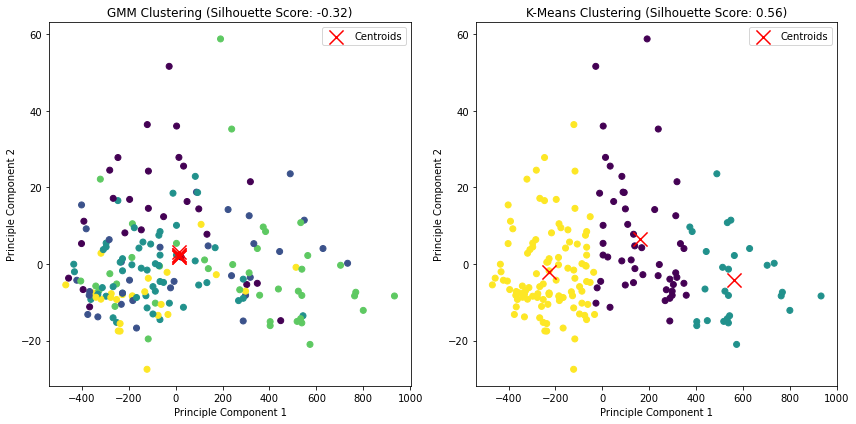

In [265]:
# Plot scatter plots for GMM and K-Means
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=parameters["membership"], cmap='viridis')
plt.scatter(parameters["means"][:, 0], parameters["means"][:, 1], c='red', marker='x', s=200, label='Centroids')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title(f'GMM Clustering (Silhouette Score: {silhouette_gmm:.2f})')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_assignments, cmap='viridis')
plt.scatter(means[:, 0], means[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title(f'K-Means Clustering (Silhouette Score: {silhouette_kmeans:.2f})')
plt.legend()

plt.tight_layout()
plt.show()

##### Obersvation: The Silhouette Score of K-Means Clustering is more than that of the GMM. This means quality of cluserting is good in K-means